In [4]:

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pandas import datetime
import os
import pandas as pd
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

In [5]:
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line, cut_off, channel, type_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.xlabel('Time [10ms]')
    plt.ylabel('Signal')
    plt.title('%s' % type_data + ' EEG data for channel %d' % channel)
    plt.legend()
    if make_line:
        plt.axvline(x=cut_off + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()
def invert_scale(scaler, X):
    X = X.reshape(-1,1)
    inverted = scaler.inverse_transform(X)
    return inverted[:, 0]

In [6]:
import pickle 

pickle_file = open('LSTM/output-data/3channel_LSTM_data_SC4002E0-PSG.pkl', 'r')
params = pickle.load(pickle_file)
scalers = pickle.load(pickle_file)
pred_data = pickle.load(pickle_file)
true_data = pickle.load(pickle_file)
pickle_file.close()

In [7]:
cut_off = params['cut_off']
print(cut_off)
y_train = true_data[:,:params['cut_off']]
y_test = true_data[:,params['cut_off']:]
predicted_train = pred_data[:,:params['cut_off']]
predicted_test = pred_data[:,params['cut_off']:]
print y_train.shape, y_test.shape, predicted_train.shape, predicted_test.shape

8769
(3, 8769) (3, 974) (3, 8769) (3, 974)


In [8]:
mse_test = []
mse_train = []
for i in range(predicted_train.shape[0]):
    mse_test.append(mean_squared_error(y_test[:,i], predicted_test[:,i]))
    mse_train.append(mean_squared_error(y_train[:,i], predicted_train[:,i]))
print mse_test
print mse_train


[0.010837505662777252, 0.001712505779187401, 0.002935433163445698]
[0.001613802681773977, 0.005047297999201546, 0.0009874558730858885]


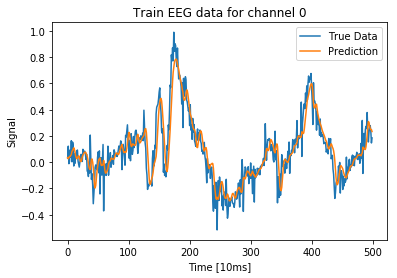

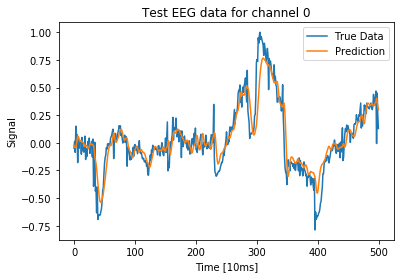

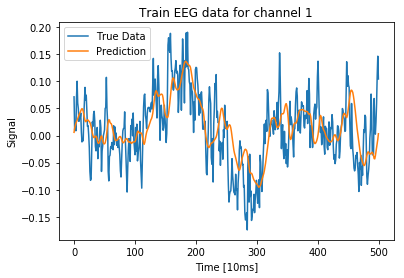

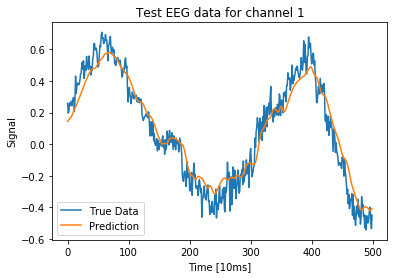

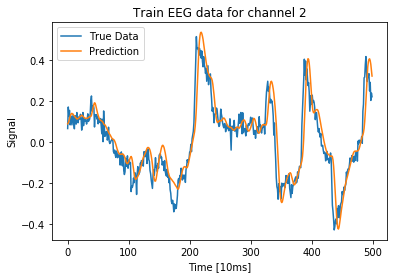

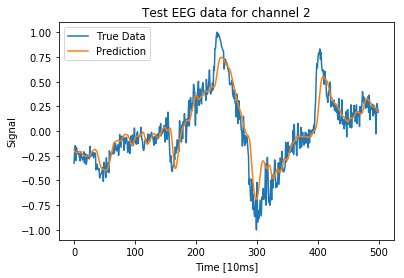

In [9]:
for i in range(params['nchannels']): 
    plot_results(predicted_train[i, :500], y_train[i,:500], False, params['cut_off'], i, 'Train')
    #plot_results(pred_data[i,:], true_data[i,:], True, params['cut_off'], i, 'All')
    plot_results(predicted_test[i,:500], y_test[i, :500], False, params['cut_off'], i, 'Test')

In [10]:
mae_test = []
mae_train = []
for i in range(params['nchannels']):
    mae_test.append(mean_absolute_error(y_test[:,i], predicted_test[:,i]))
    mae_train.append(mean_absolute_error(y_train[:,i], predicted_train[:,i]))
print mae_test
print mae_train

[0.09234428287980316, 0.03589643124477612, 0.053807526947136676]
[0.030424492456951068, 0.05851953708360249, 0.025831102538839083]


In [11]:
inv_pred_data = np.zeros(pred_data.shape)
print pred_data.shape
inv_true_data = np.zeros(true_data.shape)
for i in range(pred_data.shape[0]):
    inv_pred_data[i,:] = invert_scale(scalers[i],pred_data[i,:])
    print(inv_pred_data.shape)
    inv_true_data[i,:] = invert_scale(scalers[i],true_data[i,:])
    print(inv_true_data.shape)

(3, 9743)
(3, 9743)
(3, 9743)
(3, 9743)
(3, 9743)
(3, 9743)
(3, 9743)


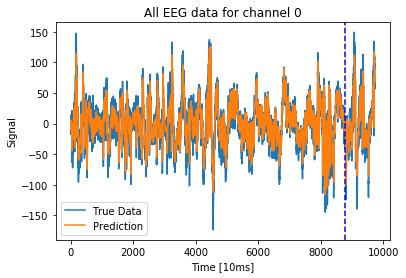

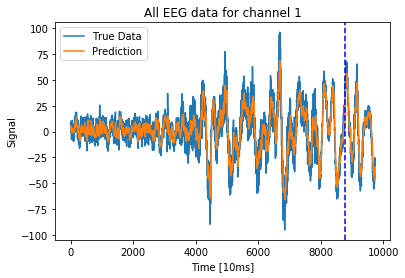

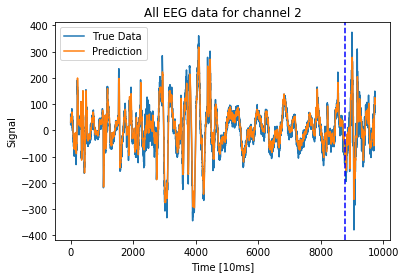

In [12]:
for i in range(pred_data.shape[0]): 
    plot_results(inv_pred_data[i,:], inv_true_data[i,:], True, params['cut_off'], i, 'All')

97.43
97.43


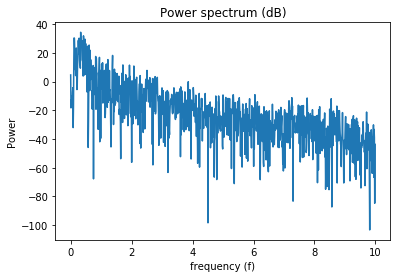

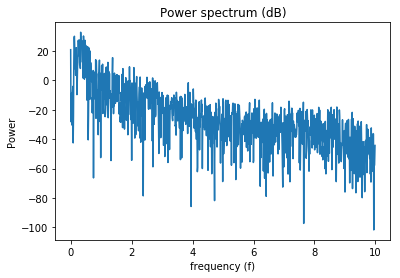

97.43
97.43


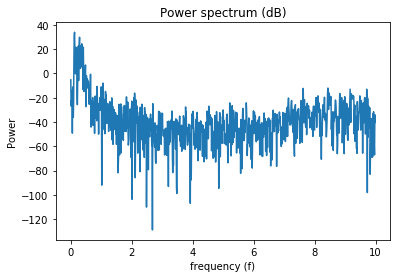

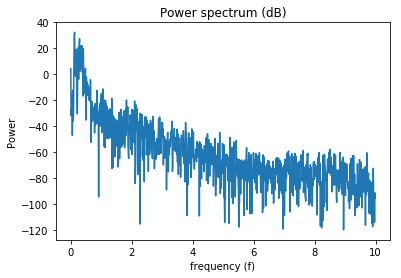

97.43
97.43


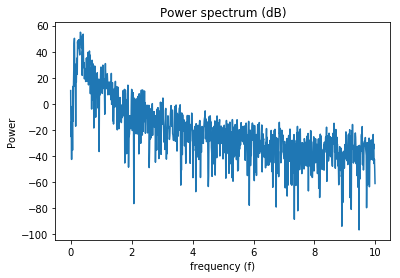

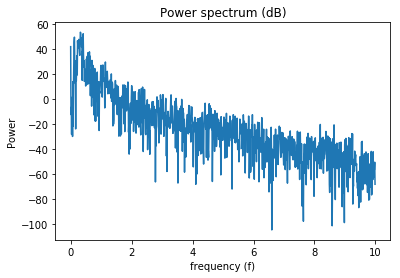

In [13]:
from __future__ import division

for i in range(inv_true_data.shape[0]):
    Fs = 100
    T = len(inv_true_data[i,:])/Fs
    print T
    N = Fs*T
    print(T)
    inv_true_data_w = np.fft.fft(inv_true_data[i,:])/N
    power_inv_true_data = abs(inv_true_data_w)**2

    inv_pred_data_w = np.fft.fft(inv_pred_data[i,:])/N
    power_inv_pred_data = abs(inv_pred_data_w)**2
    w = np.arange(0,Fs,1/T)
    plt.plot(w[:int(N/10)], 10*np.log(power_inv_true_data[:int(N/10)]))
    plt.ylabel('Power')
    plt.xlabel('frequency (f)')
    plt.title('Power spectrum (dB)')

    plt.show()
    plt.ylabel('Power')
    plt.xlabel('frequency (f)')
    plt.title('Power spectrum (dB)')
    #plt.ylim([0,0.55])
    plt.plot(w[:int(N/10)], 10*np.log(power_inv_pred_data[:int(N/10)]))

    plt.show()

5.0


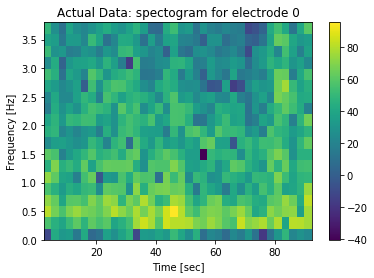

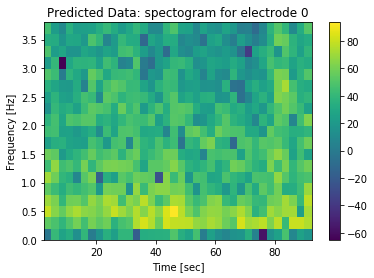

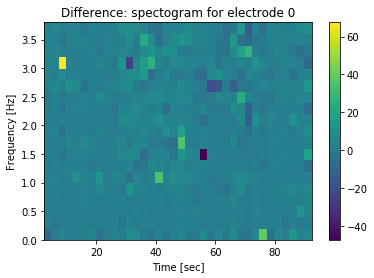

5.0


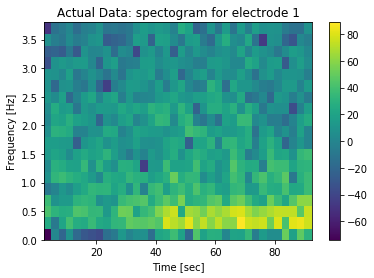

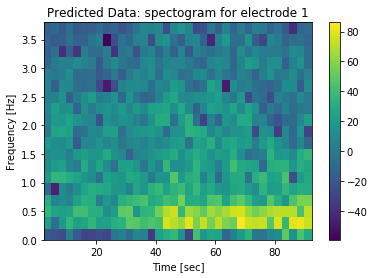

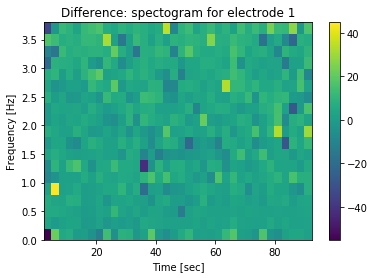

5.0


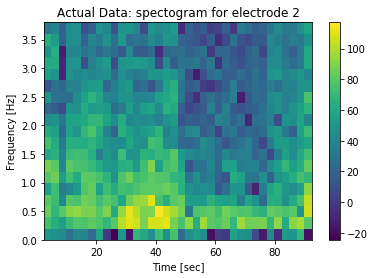

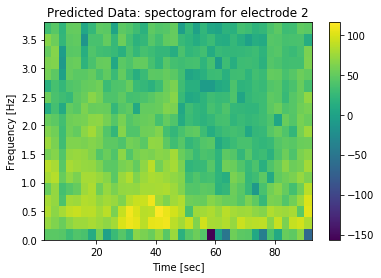

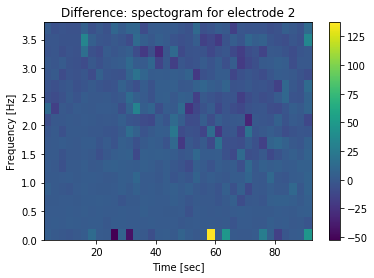

In [14]:
from scipy import signal
time_chunk = 500
for i in range(inv_true_data.shape[0]):
    Fs = 100
    T = time_chunk/Fs
    print T
    N = Fs*T
    f, t, Sxx_act = signal.spectrogram(inv_true_data[i,:time_chunk*19], Fs, nperseg=time_chunk, noverlap=time_chunk*0.5)
    plt.pcolormesh(t, f[:20], 10*np.log(Sxx_act[:20,:37]))
    plt.title('Actual Data: spectogram for electrode %d' % i)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()
    
    
    f, t, Sxx_pred = signal.spectrogram(inv_pred_data[i,:time_chunk*19], Fs, nperseg=time_chunk, noverlap=time_chunk*0.5)
    plt.pcolormesh(t, f[:20], 10*np.log(Sxx_pred[:20,:37]))
    plt.title('Predicted Data: spectogram for electrode %d' % i)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()
    
    plt.pcolormesh(t, f[:20], 10*(np.log(Sxx_act[:20,:37]/Sxx_pred[:20,:37])))
    plt.title('Difference: spectogram for electrode %d' % i)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()
    

In [15]:
mae_test = []
mae_train = []
for i in range(predicted_train.shape[0]):
    mae_test.append(mean_absolute_error(inv_pred_data[:], inv_true_data[:]))
print mae_test


[11.876388758372167, 11.876388758372167, 11.876388758372167]


In [16]:
mse_test = []
mse_train = []
for i in range(predicted_train.shape[0]):
    mse_test.append(mean_squared_error(inv_pred_data[:,i], inv_true_data[:,i]))
print mse_test



[38.55370776101093, 361.82697574594425, 48.62444835978446]
